In [1]:
import sys
# sys.path.append(r'E:/0code')
# sys.path.append(r'/home/wyf/0code')
# sys.path.append(r'/home/wangyf226/0code')
sys.path.append(r'/BIGDATA1/nsccgz_yfdu_1/asc19/wyf/0code')

In [55]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import datetime
from pyml.ensemble.regression import GradientBoostingRegression
from pyml.tree.regression import DecisionTreeRegressor
from pyml.feature_extraction.text import CountVectorizer
from pyml.linear_model.regression import LinearRegression
from pyml.neighbors.classification import KNeighborsClassifier
from pyml.metrics.regression import pearson_correlation
from pyml.model_selection import KFold
from pyml.model_selection import ShuffleSplit
from pyml.preprocessing import StandardScaler
from pyml.logger import logger
from sklearn.preprocessing import MinMaxScaler
import logging
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def save_model(model, name):
    with open(name,'wb') as f:
        pickle.dump(model, f)
def load_model(name):
    with open(name,'rb') as f:
        pickle.load(f,model)
    return model

In [23]:
# # 读取数据文件
train = pd.read_excel('../data/train.xlsx')
test = pd.read_excel('../data/testStudent.xlsx')

In [5]:
# 增加里tags特征的属性
train = pd.read_excel('../data/train_add_feat_score.xlsx')
test = pd.read_excel('../data/test_add_feat_score.xlsx')

In [6]:
train.dtypes # 检查有没有数据类型错误的，比如原本是int的变成str，说明里面可能有nan值等奇怪的数据

Additional_Number_of_Scoring                    int64
Average_Score                                 float64
Review_Total_Negative_Word_Counts               int64
Total_Number_of_Reviews                         int64
Review_Total_Positive_Word_Counts               int64
Total_Number_of_Reviews_Reviewer_Has_Given      int64
Reviewer_Score                                float64
TripType_score                                  int64
traveler_type_score                             int64
order_type_score                                int64
nights_num_score                                int64
with_pet_score                                  int64
room_type_score                                 int64
dtype: object

In [24]:
train_ori_X = train.drop('Reviewer_Score', axis=1).drop('Tags', axis=1)
train_ori_Y = train['Reviewer_Score']
test_ori_X = test.drop('Tags', axis=1)

In [7]:
train_ori_X = train.drop('Reviewer_Score', axis=1)
train_ori_Y = train['Reviewer_Score']
test_ori_X = test

## 特征处理

In [25]:
# 特征方案0：不设置任何特征
train_X_feat = train_ori_X
test_X_feat = test_ori_X

In [26]:
# 查看不同特征与分数的相关系数
for feat_name in train_X_feat:
    print("{} : {}".format(feat_name, pearson_correlation(train_X_feat[feat_name].values, train_ori_Y.values)))

Additional_Number_of_Scoring : -0.06342829612443443
Average_Score : 0.3622534338191119
Review_Total_Negative_Word_Counts : -0.38232451404246
Total_Number_of_Reviews : -0.0715884558642013
Review_Total_Positive_Word_Counts : 0.22370965918084224
Total_Number_of_Reviews_Reviewer_Has_Given : 0.002496175494613464


In [ ]:
drop_feature_names = ['Total_Number_of_Reviews_Reviewer_Has_Given', 'with_pet_score']
for drop_feature_name in drop_feature_names:
    train_X_feat = train_X_feat.drop(labels=drop_feature_name, axis=1)
    test_X_feat = test_X_feat.drop(labels=drop_feature_name, axis=1)

# 归一化，可选择不同方案

In [27]:
# 方案一：没有权重
ss = StandardScaler()
train_X = ss.fit_transform(train_X_feat.values)
test_X = ss.transform(test_X_feat.values)
train_Y = train_ori_Y

In [ ]:
# 方案二：设置部分列的权重
ss = StandardScaler()
train_X = ss.fit_transform(train_X_feat.values)
test_X = ss.transform(test_X_feat.values)
# 增加某些特征的权重
train_X[:,1] *= 4
train_X[:,2] *= 4
train_X[:,4] *= 2
train_X[:,5] *= 2
train_X[:,9] *= 3

In [30]:
mm = MinMaxScaler()
train_X = mm.fit_transform(train_X_feat.values)
test_X = mm.transform(test_X_feat.values)

In [31]:
train_X.shape,train_Y.shape,test_X.shape

((80000, 6), (80000,), (30000, 6))

In [22]:
np.save('wyf-train_X-80000-12',train_X)
np.save('wyf-test_X-30000-12', test_X)
np.save('wyf-train_Y-80000', train_Y)

In [34]:
np.save('wyf-train_X-80000-6-minmax',train_X)
np.save('wyf-test_X-30000-6-minmax', test_X)

In [28]:
np.save('wyf-train_X-80000-6-standard',train_X)
np.save('wyf-test_X-30000-6-standard', test_X)

## 交叉验证(使用12维的数据）

In [56]:
train_X = np.load('wyf-train_X-80000-12.npy')
test_X = np.load('wyf-test_X-30000-12.npy')
train_Y = np.load('wyf-train_Y-80000.npy')

## 使用对半划分选最优的方法

In [58]:
logger.setLevel(logging.INFO)
max_node_sizes = [10,20,40,80,160,320,500, 640]
n_splits = 1
cv = ShuffleSplit(n_splits=n_splits)
train_scores = []
valid_scores = []
models_1 = []
for train_indices, test_indices in cv.split(train_X):
    for max_node_size in max_node_sizes:
        lr = DecisionTreeRegressor(max_node_size=max_node_size, divide_way='half')
        lr.fit(train_X[train_indices], train_Y[train_indices])
        y_pred = lr.predict(train_X[test_indices])
        y_train_pred = lr.predict(train_X[train_indices])
        train_score = pearson_correlation(y_train_pred, train_Y[train_indices])
        valid_score = pearson_correlation(y_pred, train_Y[test_indices])
        train_scores.append(train_score)
        valid_scores.append(valid_score)
        models_1.append(lr)
        logger.info("train score : {} valid score : {}".format(train_score, valid_score))

[    INFO] - [<ipython-input-58-9a663459a6a2>] - [ 19] - [  <module>] 
train score : 0.6313675313116156 valid score : 0.32838892152356114

[    INFO] - [<ipython-input-58-9a663459a6a2>] - [ 19] - [  <module>] 
train score : 0.5235955585412756 valid score : 0.3320796299499856

[    INFO] - [<ipython-input-58-9a663459a6a2>] - [ 19] - [  <module>] 
train score : 0.44352772182446204 valid score : 0.33304044292240353

[    INFO] - [<ipython-input-58-9a663459a6a2>] - [ 19] - [  <module>] 
train score : 0.4031122331446049 valid score : 0.34236645876966804

[    INFO] - [<ipython-input-58-9a663459a6a2>] - [ 19] - [  <module>] 
train score : 0.3833136129199905 valid score : 0.34867358459762016

[    INFO] - [<ipython-input-58-9a663459a6a2>] - [ 19] - [  <module>] 
train score : 0.37303591262022406 valid score : 0.35176740026015674

[    INFO] - [<ipython-input-58-9a663459a6a2>] - [ 19] - [  <module>] 
train score : 0.3674057021983524 valid score : 0.3543259131807488

[    INFO] - [<ipython-inpu

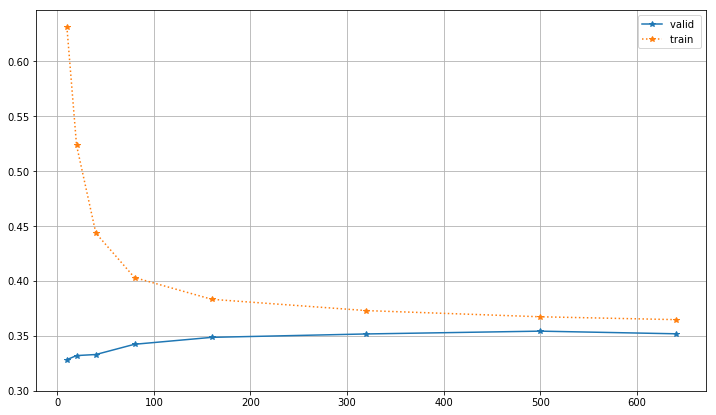

In [59]:
arguments = max_node_sizes
plt.figure(figsize=(12,7)) 
plt.plot(arguments,valid_scores,'-*',label='valid ')
plt.plot(arguments,train_scores,':*',label='train ')
plt.yticks(np.arange(0.3, 0.65, 0.05))
ax = plt.gca()
ax.grid(True)
plt.legend()

## 使用全局寻找最优的方法

In [60]:
logger.setLevel(logging.INFO)
max_node_sizes = [10,20,40,80,160,320,500, 640]
n_splits = 1
cv = ShuffleSplit(n_splits=n_splits)
train_scores = []
valid_scores = []
models_2 = []
for train_indices, test_indices in cv.split(train_X):
    for max_node_size in max_node_sizes:
        lr = DecisionTreeRegressor(max_node_size=max_node_size, divide_way='default')
        lr.fit(train_X[train_indices], train_Y[train_indices])
        y_pred = lr.predict(train_X[test_indices])
        y_train_pred = lr.predict(train_X[train_indices])
        train_score = pearson_correlation(y_train_pred, train_Y[train_indices])
        valid_score = pearson_correlation(y_pred, train_Y[test_indices])
        train_scores.append(train_score)
        valid_scores.append(valid_score)
        models_2.append(lr)
        logger.info("train score : {} valid score : {}".format(train_score, valid_score))

[    INFO] - [<ipython-input-60-46de5a45021e>] - [ 19] - [  <module>] 
train score : 0.8205870515488669 valid score : 0.5214607642038083

[    INFO] - [<ipython-input-60-46de5a45021e>] - [ 19] - [  <module>] 
train score : 0.7484737936502874 valid score : 0.5735256408023275

[    INFO] - [<ipython-input-60-46de5a45021e>] - [ 19] - [  <module>] 
train score : 0.702481877760663 valid score : 0.6075178138838635

[    INFO] - [<ipython-input-60-46de5a45021e>] - [ 19] - [  <module>] 
train score : 0.6758229349824433 valid score : 0.6273904791271216

[    INFO] - [<ipython-input-60-46de5a45021e>] - [ 19] - [  <module>] 
train score : 0.6608375911256202 valid score : 0.633256449035839

[    INFO] - [<ipython-input-60-46de5a45021e>] - [ 19] - [  <module>] 
train score : 0.6506707074967651 valid score : 0.6339379750492868

[    INFO] - [<ipython-input-60-46de5a45021e>] - [ 19] - [  <module>] 
train score : 0.6416884794203707 valid score : 0.632107349396803

[    INFO] - [<ipython-input-60-46de5

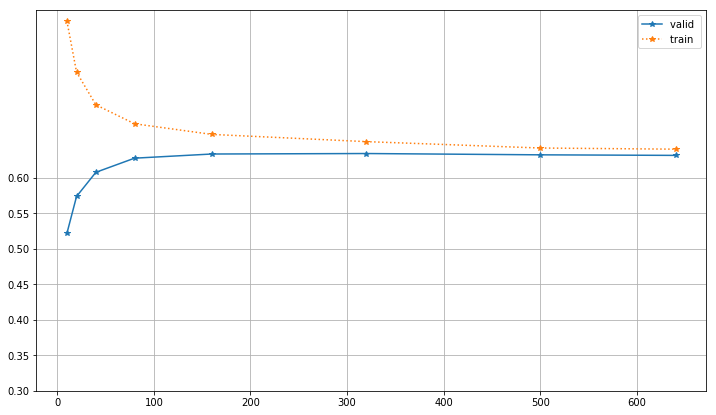

In [61]:
arguments = max_node_sizes
plt.figure(figsize=(12,7)) 
plt.plot(arguments,valid_scores,'-*',label='valid ')
plt.plot(arguments,train_scores,':*',label='train ')
plt.yticks(np.arange(0.3, 0.84, 0.02))
ax = plt.gca()
ax.grid(True)
plt.legend()

# 使用原始数据，归一化成标准分布

In [73]:
train_X = np.load('wyf-train_X-80000-6-standard.npy')
test_X = np.load('wyf-test_X-30000-6-standard.npy')
train_Y = np.load('wyf-train_Y-80000.npy')

In [74]:
logger.setLevel(logging.INFO)
max_node_sizes = [10,20,40,80,160,320,500, 640]
n_splits = 1
cv = ShuffleSplit(n_splits=n_splits)
train_scores = []
valid_scores = []
models_3 = []
for train_indices, test_indices in cv.split(train_X):
    for max_node_size in max_node_sizes:
        lr = DecisionTreeRegressor(max_node_size=max_node_size, divide_way='half')
        lr.fit(train_X[train_indices], train_Y[train_indices])
        y_pred = lr.predict(train_X[test_indices])
        y_train_pred = lr.predict(train_X[train_indices])
        train_score = pearson_correlation(y_train_pred, train_Y[train_indices])
        valid_score = pearson_correlation(y_pred, train_Y[test_indices])
        train_scores.append(train_score)
        valid_scores.append(valid_score)
        models_3.append(lr)
        logger.info("train score : {} valid score : {}".format(train_score, valid_score))

[    INFO] - [<ipython-input-74-58262a493594>] - [ 19] - [  <module>] 
train score : 0.6535046265239404 valid score : 0.4393680610135238

[    INFO] - [<ipython-input-74-58262a493594>] - [ 19] - [  <module>] 
train score : 0.5791148756214549 valid score : 0.4325222933050009

[    INFO] - [<ipython-input-74-58262a493594>] - [ 19] - [  <module>] 
train score : 0.5195801734968561 valid score : 0.43755250827865433

[    INFO] - [<ipython-input-74-58262a493594>] - [ 19] - [  <module>] 
train score : 0.46461675839973365 valid score : 0.4233713336530215

[    INFO] - [<ipython-input-74-58262a493594>] - [ 19] - [  <module>] 
train score : 0.4060494874704719 valid score : 0.39024644299129835

[    INFO] - [<ipython-input-74-58262a493594>] - [ 19] - [  <module>] 
train score : 0.37231319809756575 valid score : 0.36724915130934455

[    INFO] - [<ipython-input-74-58262a493594>] - [ 19] - [  <module>] 
train score : 0.3654164584443832 valid score : 0.3674626251415184

[    INFO] - [<ipython-input-

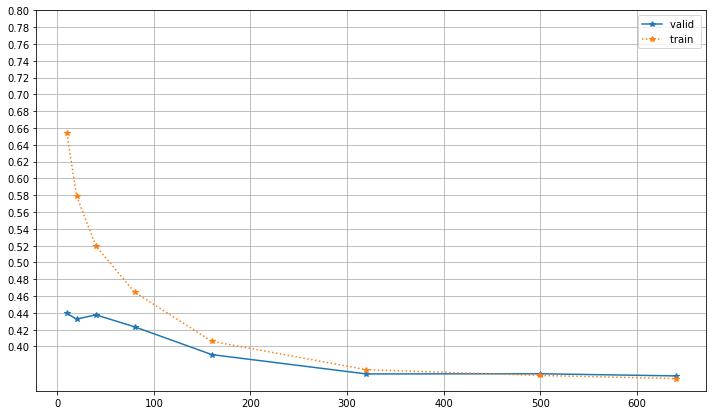

In [75]:
arguments = max_node_sizes
plt.figure(figsize=(12,7)) 
plt.plot(arguments,valid_scores,'-*',label='valid ')
plt.plot(arguments,train_scores,':*',label='train ')
plt.yticks(np.arange(0.4, 0.82, 0.02))
ax = plt.gca()
ax.grid(True)
plt.legend()

In [76]:
logger.setLevel(logging.INFO)
max_node_sizes = [10,20,40,80,160,320,500, 640]
n_splits = 1
cv = ShuffleSplit(n_splits=n_splits)
train_scores = []
valid_scores = []
models_4 = []
for train_indices, test_indices in cv.split(train_X):
    for max_node_size in max_node_sizes:
        lr = DecisionTreeRegressor(max_node_size=max_node_size, divide_way='default')
        lr.fit(train_X[train_indices], train_Y[train_indices])
        y_pred = lr.predict(train_X[test_indices])
        y_train_pred = lr.predict(train_X[train_indices])
        train_score = pearson_correlation(y_train_pred, train_Y[train_indices])
        valid_score = pearson_correlation(y_pred, train_Y[test_indices])
        train_scores.append(train_score)
        valid_scores.append(valid_score)
        models_4.append(lr)
        logger.info("train score : {} valid score : {}".format(train_score, valid_score))

[    INFO] - [<ipython-input-76-acfd26434ebe>] - [ 19] - [  <module>] 
train score : 0.7962562942848741 valid score : 0.5218893024068043

[    INFO] - [<ipython-input-76-acfd26434ebe>] - [ 19] - [  <module>] 
train score : 0.7328255081373011 valid score : 0.5701656409741666

[    INFO] - [<ipython-input-76-acfd26434ebe>] - [ 19] - [  <module>] 
train score : 0.692660666076873 valid score : 0.5992865879577607

[    INFO] - [<ipython-input-76-acfd26434ebe>] - [ 19] - [  <module>] 
train score : 0.6703289384287584 valid score : 0.6182454780744575

[    INFO] - [<ipython-input-76-acfd26434ebe>] - [ 19] - [  <module>] 
train score : 0.657421657038805 valid score : 0.6250700054311102

[    INFO] - [<ipython-input-76-acfd26434ebe>] - [ 19] - [  <module>] 
train score : 0.6490885615051346 valid score : 0.6252677617889224

[    INFO] - [<ipython-input-76-acfd26434ebe>] - [ 19] - [  <module>] 
train score : 0.6417100998197998 valid score : 0.6229823467764328

[    INFO] - [<ipython-input-76-acfd

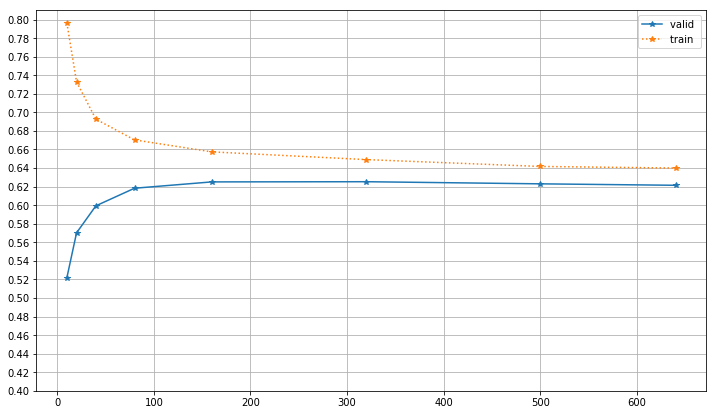

In [77]:
arguments = max_node_sizes
plt.figure(figsize=(12,7)) 
plt.plot(arguments,valid_scores,'-*',label='valid ')
plt.plot(arguments,train_scores,':*',label='train ')
plt.yticks(np.arange(0.4, 0.82, 0.02))
ax = plt.gca()
ax.grid(True)
plt.legend()

# 使用原始数据，归一化成0-1之间的数

In [67]:
train_X = np.load('wyf-train_X-80000-6-minmax.npy')
test_X = np.load('wyf-test_X-30000-6-minmax.npy')
train_Y = np.load('wyf-train_Y-80000.npy')

In [68]:
logger.setLevel(logging.INFO)
max_node_sizes = [10,20,40,80,160,320,500, 640]
n_splits = 1
cv = ShuffleSplit(n_splits=n_splits)
train_scores = []
valid_scores = []
models_5 = []
for train_indices, test_indices in cv.split(train_X):
    for max_node_size in max_node_sizes:
        lr = DecisionTreeRegressor(max_node_size=max_node_size, divide_way='half')
        lr.fit(train_X[train_indices], train_Y[train_indices])
        y_pred = lr.predict(train_X[test_indices])
        y_train_pred = lr.predict(train_X[train_indices])
        train_score = pearson_correlation(y_train_pred, train_Y[train_indices])
        valid_score = pearson_correlation(y_pred, train_Y[test_indices])
        train_scores.append(train_score)
        valid_scores.append(valid_score)
        models_5.append(lr)
        logger.info("train score : {} valid score : {}".format(train_score, valid_score))

[    INFO] - [<ipython-input-68-28aa1acb9adc>] - [ 19] - [  <module>] 
train score : 0.6540633299132941 valid score : 0.4289771699036664

[    INFO] - [<ipython-input-68-28aa1acb9adc>] - [ 19] - [  <module>] 
train score : 0.579797602186592 valid score : 0.4331588127841937

[    INFO] - [<ipython-input-68-28aa1acb9adc>] - [ 19] - [  <module>] 
train score : 0.5207949927556771 valid score : 0.4303738524087957

[    INFO] - [<ipython-input-68-28aa1acb9adc>] - [ 19] - [  <module>] 
train score : 0.4634719217869018 valid score : 0.4082821990891971

[    INFO] - [<ipython-input-68-28aa1acb9adc>] - [ 19] - [  <module>] 
train score : 0.4045457688398727 valid score : 0.3742043047585383

[    INFO] - [<ipython-input-68-28aa1acb9adc>] - [ 19] - [  <module>] 
train score : 0.37261408914950267 valid score : 0.36228282266689515

[    INFO] - [<ipython-input-68-28aa1acb9adc>] - [ 19] - [  <module>] 
train score : 0.3668195486688922 valid score : 0.35961171897872035

[    INFO] - [<ipython-input-68-

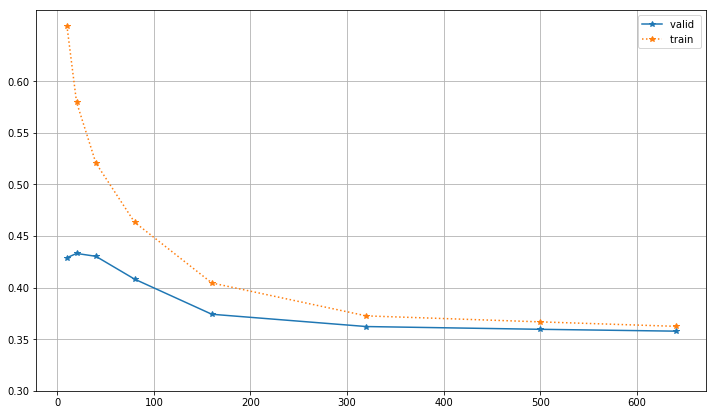

In [69]:
arguments = max_node_sizes
plt.figure(figsize=(12,7)) 
plt.plot(arguments,valid_scores,'-*',label='valid ')
plt.plot(arguments,train_scores,':*',label='train ')
plt.yticks(np.arange(0.4, 0.82, 0.02))
ax = plt.gca()
ax.grid(True)
plt.legend()

In [70]:
logger.setLevel(logging.INFO)
max_node_sizes = [10,20,40,80,160,320,500, 640]
n_splits = 1
cv = ShuffleSplit(n_splits=n_splits)
train_scores = []
valid_scores = []
models_6 = []
for train_indices, test_indices in cv.split(train_X):
    for max_node_size in max_node_sizes:
        lr = DecisionTreeRegressor(max_node_size=max_node_size, divide_way='default')
        lr.fit(train_X[train_indices], train_Y[train_indices])
        y_pred = lr.predict(train_X[test_indices])
        y_train_pred = lr.predict(train_X[train_indices])
        train_score = pearson_correlation(y_train_pred, train_Y[train_indices])
        valid_score = pearson_correlation(y_pred, train_Y[test_indices])
        train_scores.append(train_score)
        valid_scores.append(valid_score)
        models_6.append(lr)
        logger.info("train score : {} valid score : {}".format(train_score, valid_score))

[    INFO] - [<ipython-input-70-4d0b98d8844f>] - [ 19] - [  <module>] 
train score : 0.7956478279162287 valid score : 0.5490809308592275

[    INFO] - [<ipython-input-70-4d0b98d8844f>] - [ 19] - [  <module>] 
train score : 0.7324636070196616 valid score : 0.5932971001554815

[    INFO] - [<ipython-input-70-4d0b98d8844f>] - [ 19] - [  <module>] 
train score : 0.6924946672379055 valid score : 0.6223430494224411

[    INFO] - [<ipython-input-70-4d0b98d8844f>] - [ 19] - [  <module>] 
train score : 0.6699204404993269 valid score : 0.6357650502562681

[    INFO] - [<ipython-input-70-4d0b98d8844f>] - [ 19] - [  <module>] 
train score : 0.6567521722119435 valid score : 0.6455049884294335

[    INFO] - [<ipython-input-70-4d0b98d8844f>] - [ 19] - [  <module>] 
train score : 0.6480758644972631 valid score : 0.645300799457147

[    INFO] - [<ipython-input-70-4d0b98d8844f>] - [ 19] - [  <module>] 
train score : 0.6405460522047116 valid score : 0.639232408220525

[    INFO] - [<ipython-input-70-4d0b

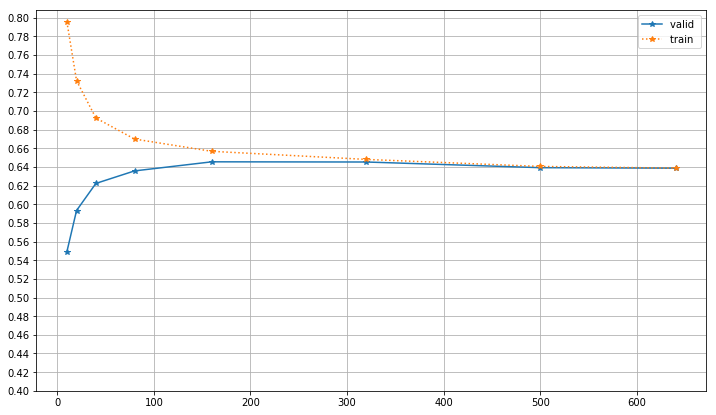

In [72]:
arguments = max_node_sizes
plt.figure(figsize=(12,7)) 
plt.plot(arguments,valid_scores,'-*',label='valid ')
plt.plot(arguments,train_scores,':*',label='train ')
plt.yticks(np.arange(0.4, 0.82, 0.02))
ax = plt.gca()
ax.grid(True)
plt.legend()